In [120]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

## Simple nudging algorithm for Lorenz96

## Set Up

Get "true" state for Lorenz96

In [121]:
def lorenz96(x, F=8):
    N = len(x)
    dx = np.zeros(N)
    for k in range(N):
        dx[k] = (x[(k+1)%N] - x[k-2]) * x[k-1] - x[k] + F
    return dx

def make_truth_and_obs(N, F_forcing=8.0, T=10.0, dt=0.01, obs_indices=None, obs_noise_std=0.5, seed=0):
    np.random.seed(seed)
    t = np.arange(0, T+1e-12, dt)
    M = t.size
    # generate truth with solve_ivp (RK45)
    def rhs(t_, y):
        return lorenz96(y, F_forcing)
    x0 = F_forcing * np.ones(N)  # typical L96 initial guess
    x0[int(np.ceil(N/2))] += 0.01  # small perturbation
    sol = solve_ivp(rhs, [0, T], x0, t_eval=t, method="DOP853", rtol=1e-8, atol=1e-10)
    truth = sol.y.T  # shape (M, N)

    if obs_indices is None:
        # observe every other variable as an example
        obs_indices = np.arange(0, N, 2)

    obs_times = t.copy()
    obs_values = truth[:, obs_indices].copy()
    # add Gaussian noise to observations
    obs_values += np.random.normal(0.0, obs_noise_std, size=obs_values.shape)

    return t, truth, obs_times, obs_values, obs_indices


In [122]:
T = 10
N = 6
n = 10000
dt = T / (n-1)
obs_idx = [0,1,3,4]         # indices of observed variables
hid_idx = [i for i in range(N) if i not in obs_idx]  # hidden variables

t, truth, obs_t, obs_vals, obs_idx = make_truth_and_obs(N=N, F_forcing=8.0, T=10.0, dt=dt,
                                                       obs_indices=obs_idx, obs_noise_std=0.5)
uI = truth[obs_idx]    
uII = truth[hid_idx]  

In [123]:
u = np.zeros((N,n))

u[:,0] = truth[0]

k = 10
K = np.zeros((N, len(obs_idx)))
for j, i in enumerate(obs_idx):
    K[i, j] = k


for i in range(1, n): 
    u_prev = u[:,i-1]

    Hu = u_prev[obs_idx]
    obs = truth[i-1,obs_idx]
    F = lorenz96(u_prev)
    u[:,i] = u[:,i-1] + dt*(F + K@(obs - Hu))

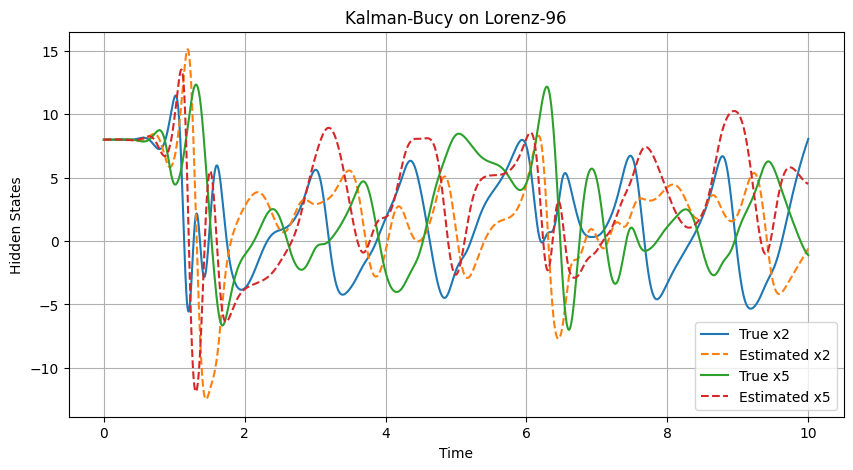

In [124]:
t_vals = np.linspace(0,T,n)
plt.figure(figsize=(10,5))
for i in range(min(2, len(hid_idx))):
    plt.plot(t_vals, truth[:, hid_idx[i]], label=f'True x{hid_idx[i]}')
    plt.plot(t_vals, u[i], '--', label=f'Estimated x{hid_idx[i]}')
plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.legend()
plt.title("Kalman-Bucy on Lorenz-96")
plt.grid()
plt.show()


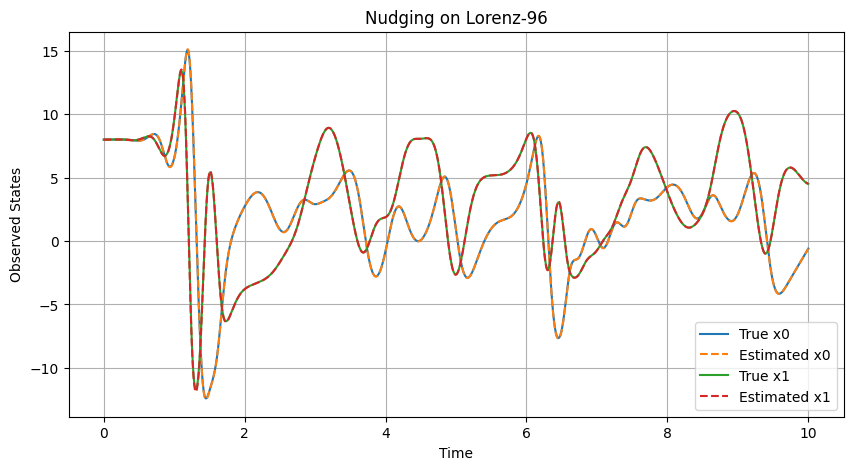

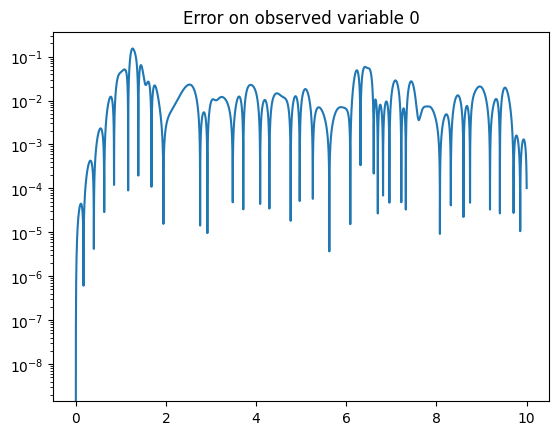

In [125]:
t_vals = np.linspace(0,T,n)
plt.figure(figsize=(10,5))
for i in range(min(2, len(obs_idx))):
    plt.plot(t_vals, truth[:, obs_idx[i]], label=f'True x{obs_idx[i]}')
    plt.plot(t_vals, u[i], '--', label=f'Estimated x{obs_idx[i]}')
plt.xlabel("Time")
plt.ylabel("Observed States")
plt.legend()
plt.title("Nudging on Lorenz-96")
plt.grid()
plt.show()

i = 0
plt.semilogy(t_vals, abs(truth[:, obs_idx[i]] - u[i]))
plt.title(f"Error on observed variable {obs_idx[i]}")
plt.show()

## Multiscale 

all slow variables are observed

In [130]:


def lorenz96_multiscale(u, v, dt, hc, hv, eps, F = 8):
    N,J = v.shape
    du = np.zeros(N)
    for i in range(N):
        du[i] = (u[(i+1)%N] - u[i-2]) * u[i-1] - u[i] + F -(hc/J)*np.sum(v[i])
    dv = np.zeros((N,J))
    for i in range(N):
        for j in range(J):
            dv[i,j] = (1/eps)*(hv*u[i] + v[i,(j+1)%J]*(v[i,(j-1)%J] - v[i,(j+2)%J]) - v[i,j])

    return u + dt*du, v + dt*dv


In [131]:


def lorenz96_multiscale(u, v, dt, hc, hv, eps, F = 8):
    N,J = v.shape
    du = np.zeros(N)
    for i in range(N):
        du[i] = (u[(i+1)%N] - u[i-2]) * u[i-1] - u[i] + F -(hc/J)*np.sum(v[i])
    dv = np.zeros((N,J))
    for i in range(N):
        for j in range(J):
            dv[i,j] = (1/eps)*(hv*u[i] + v[i,(j+1)%J]*(v[i,(j-1)%J] - v[i,(j+2)%J]) - v[i,j])

    return du, dv

N = 8
J = 32
F = 8
T = 2
hc = 1
hv = 1
n = 20000
eps = .2
x = np.random.randn(N)  # initial condition
dt = T / (n-1)

obs_idx = np.arange(N)
# generate true system
X_traj = np.zeros((n,N))
Y_traj = np.zeros((n,N,J))
X_traj[0] = np.random.randn(N)
Y_traj[0] = np.random.randn(N,J)
for i in range(1,n):
    du,dv = lorenz96_multiscale(X_traj[i-1], Y_traj[i-1],dt,hc,hv,eps,F)
    X_traj[i] = X_traj[i-1] + dt*du
    Y_traj[i] = Y_traj[i-1] + dt*dv 
X_true = X_traj.copy()
for i in range(1,n):
    X_traj[i] += .5*np.random.randn(N)
    
uI_obs = X_traj[0, obs_idx]
 # observed
uII_0 = Y_traj[0].flatten()
# u = nudging_multiscale(t, truth, obs_idx, K_gain, N, J, dt)
K = 5
# def nudging_multiscale(t, truth, obs_idx, K_gain, N, J, dt, F=10.0, h=1.0, c=10.0, b=10.0):
full_dim = N + N*J
u = np.zeros((n, full_dim))

u[0] = np.concatenate((uI_obs,uII_0)) + np.random.normal(0, 0.5, size=full_dim)  # slightly perturbed initial condition

for i in range(1, n):
    X = u[i-1, :N]
    Y = u[i-1, N:].reshape(N, J)
    
    # model tendency
    du, dv = lorenz96_multiscale(u[i-1,:N],u[i-1,N:].reshape((N,J)), dt, hc, hv, eps, F)
    
    # observation nudging (only slow variables)
    obs = X_traj[i-1, obs_idx]
    Hu = X[obs_idx]
    nudging_term = np.zeros(N)

    nudging_term[obs_idx] = K * (obs - Hu)
    
    dX = du + nudging_term
    dY = dv.flatten()
    
    u[i, :N] = X + dt * dX
    u[i, N:] = Y.flatten() + dt * dY


# extract nudged slow variables
X_nudged = u[:, :N]
Y_nudged = u[:,N:]


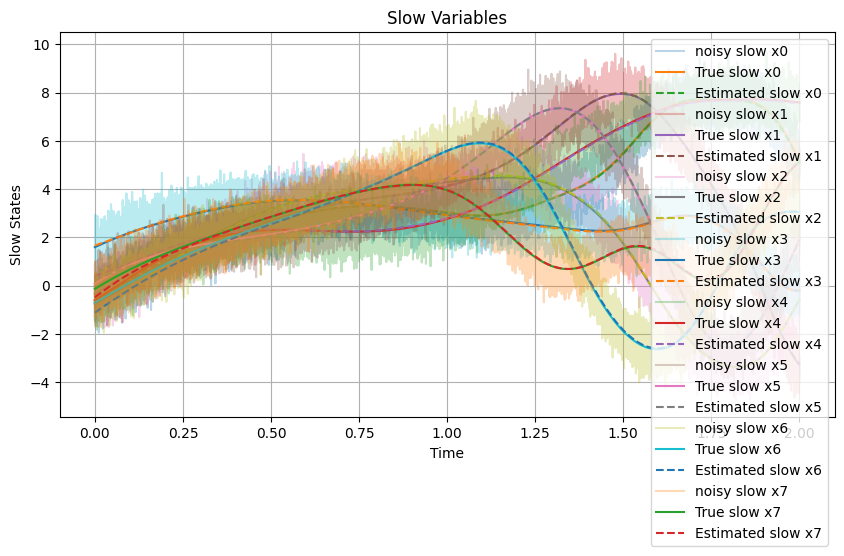

<Figure size 1200x600 with 0 Axes>

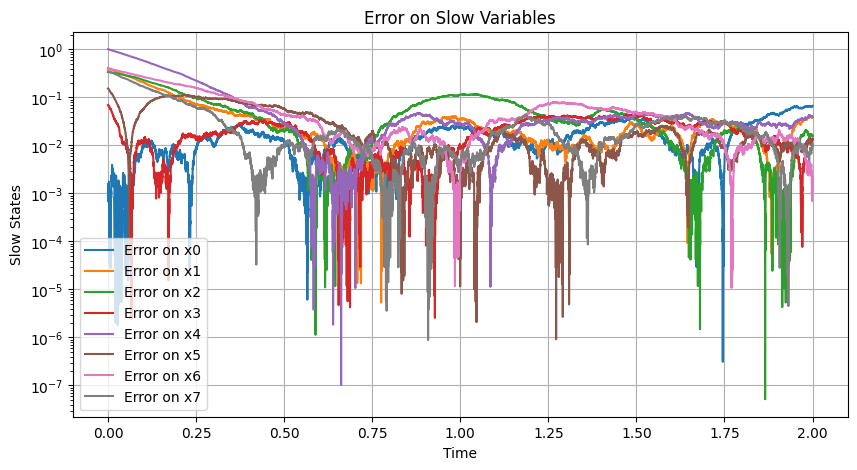

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [132]:
t_vals = np.linspace(0,T,n)
# plot slow variables
plt.figure(figsize=(10,5))
for i, idx in enumerate(obs_idx):
    plt.plot(t_vals, X_traj[:, idx], alpha = .3, label=f'noisy slow x{idx}')
    plt.plot(t_vals, X_true[:, idx], label=f'True slow x{idx}')
    plt.plot(t_vals, X_nudged[:,i], '--', label=f'Estimated slow x{idx}')
plt.xlabel("Time")
plt.ylabel("Slow States")
plt.legend()
plt.title("Slow Variables")
plt.grid()
plt.show()

plt.figure(figsize=(12,6))

# plot slow variables
plt.figure(figsize=(10,5))
for i, idx in enumerate(obs_idx):
    plt.semilogy(t_vals, np.abs(X_true[:, idx]-X_nudged[:,i]), label=f'Error on x{idx}')
plt.xlabel("Time")
plt.ylabel("Slow States")
plt.legend()
plt.title("Error on Slow Variables")
plt.grid()
plt.show()

plt.figure(figsize=(12,6))

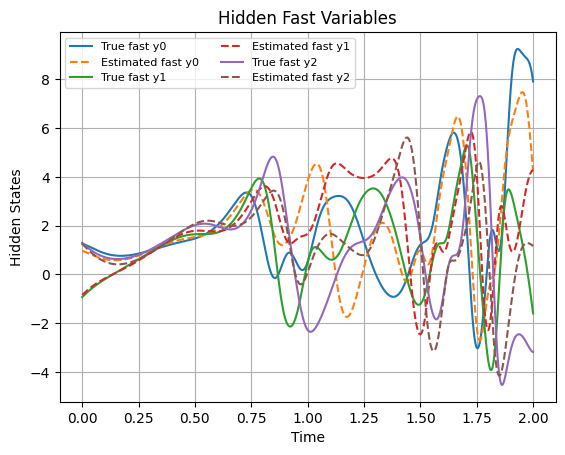

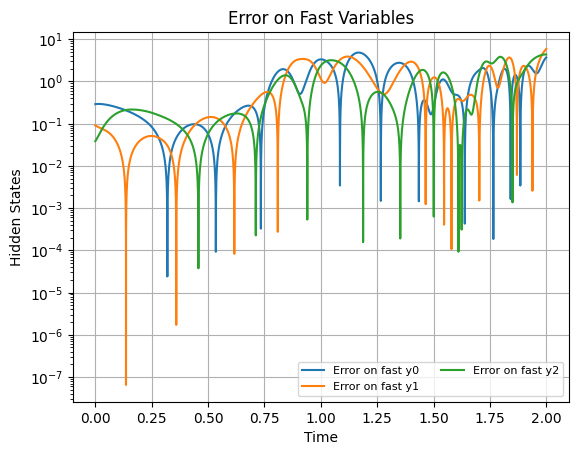

In [133]:
# plot some fast variables
num_fast_to_plot = 3
for i in range(num_fast_to_plot):
    plt.plot(t_vals, Y_traj[:, i//J, i%J], label=f'True fast y{i}')
    plt.plot(t_vals, Y_nudged[:,i], '--', label=f'Estimated fast y{i}')

plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.title("Hidden Fast Variables")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.show()

# plot some fast variables
num_fast_to_plot = 3
for i in range(num_fast_to_plot):
    plt.semilogy(t_vals, np.abs(Y_traj[:, i//J, i%J]-Y_nudged[:,i]), label=f'Error on fast y{i}')
plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.title("Error on Fast Variables")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.show()